In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images (1).npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)

In [113]:
data[0,:]

array([array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [116]:
X_train.shape

(409, 224, 224, 3)

In [117]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

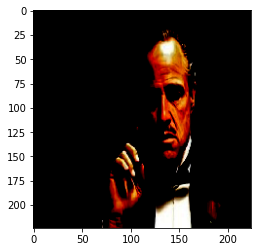

In [118]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

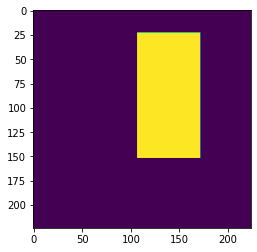

In [119]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    alpha = 1.0

    # Using Mobilenet as the encoder network. 
    # Writing decoder network here.
    block13 = model.get_layer("conv_pw_13_relu").output
    x = block13

    # Upsampling from block 13 to block 12
    x = Conv2DTranspose(int(1024 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    block12 = model.get_layer("conv_pw_12_relu").output
    x = Concatenate()([x, block12])
    x = Conv2D(1024, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 12 to block 11
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block11 = model.get_layer("conv_pw_11_relu").output
    x = Concatenate()([x, block11])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 11 to block 10
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block10 = model.get_layer("conv_pw_10_relu").output
    x = Concatenate()([x, block10])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 10 to block 9
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block9 = model.get_layer("conv_pw_9_relu").output
    x = Concatenate()([x, block9])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 9 to block 8
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block8 = model.get_layer("conv_pw_8_relu").output
    x = Concatenate()([x, block8])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   

    # Upsampling from block 8 to block 7
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block7 = model.get_layer("conv_pw_7_relu").output
    x = Concatenate()([x, block7])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 7 to block 6
    x = Conv2DTranspose(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block6 = model.get_layer("conv_pw_6_relu").output
    x = Concatenate()([x, block6])
    x = Conv2D(512, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   

    # Upsampling from block 6 to block 5
    x = Conv2DTranspose(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block5 = model.get_layer("conv_pw_5_relu").output
    x = Concatenate()([x, block5])
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    # Upsampling from block 5 to block 4
    x = Conv2DTranspose(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block4 = model.get_layer("conv_pw_4_relu").output
    x = Concatenate()([x, block4])
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 4 to block 3
    x = Conv2DTranspose(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block3 = model.get_layer("conv_pw_3_relu").output
    x = Concatenate()([x, block3])
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 3 to block 2
    x = Conv2DTranspose(int(128 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block2 = model.get_layer("conv_pw_2_relu").output
    x = Concatenate()([x, block2])
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 2 to block 1
    x = Conv2DTranspose(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    block1 = model.get_layer("conv_pw_1_relu").output
    x = Concatenate()([x, block1])
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Upsampling from block 1 to conv 1
    x = Conv2DTranspose(int(32 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv1 = model.get_layer("conv1_relu").output
    x = Concatenate()([x, conv1])
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    x = Conv2DTranspose(int(32 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = Concatenate()([UpSampling2D()(block3), block2])
    #print(type(x))
    #print(type(block3))
    #print(type(model.get_layer("conv_pw_13_relu")))

   # x = Concatenate()([UpSampling2D()(x), model.get_layer("conv_pw_1_relu").output])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((224, 224))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [131]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()


#print(model.get_layer("conv_pw_1_relu").output)
# Print summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [135]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [136]:
model.fit(X_train, masks, batch_size=1, epochs=5, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/5
409/409 [==============================] - ETA: 0s - loss: 1.1884 - dice_coefficient: 0.4755
Epoch 00001: loss improved from inf to 1.18844, saving model to model-1.19.h5
409/409 [==============================] - 51s 124ms/step - loss: 1.1884 - dice_coefficient: 0.4755 - lr: 0.0010
Epoch 2/5
409/409 [==============================] - ETA: 0s - loss: 0.9014 - dice_coefficient: 0.5759
Epoch 00002: loss improved from 1.18844 to 0.90142, saving model to model-0.90.h5
409/409 [==============================] - 51s 124ms/step - loss: 0.9014 - dice_coefficient: 0.5759 - lr: 0.0010
Epoch 3/5
409/409 [==============================] - ETA: 0s - loss: 0.8292 - dice_coefficient: 0.6058
Epoch 00003: loss improved from 0.90142 to 0.82917, saving model to model-0.83.h5
409/409 [==============================] - 51s 124ms/step - loss: 0.8292 - dice_coefficient: 0.6058 - lr: 0.0010
Epoch 4/5
409/409 [==============================] - ETA: 0s - loss: 0.7827 - dice_coefficient: 0.6236
Epoch 0

### Get the predicted mask for a sample image   (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


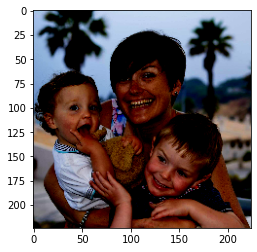

In [137]:
n = 400
sample_image = X_train[n]
pyplot.imshow(sample_image)

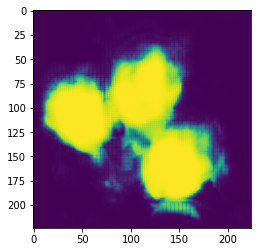

In [138]:
resized_sample_image = np.expand_dims(sample_image, axis=0)
mask = model.predict(resized_sample_image)
mask = np.reshape(mask, (224,224))
pyplot.imshow(mask)

### Impose the mask on the image (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


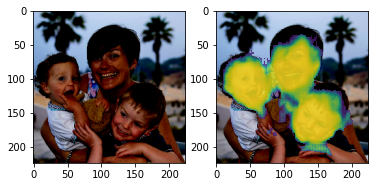

In [139]:
masked = np.ma.masked_where(mask < 0.1, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.subplot(1,2,2)
plt.imshow(sample_image)
plt.imshow(masked, alpha=0.8)
plt.show()